In [30]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [31]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

資料準備

In [32]:
batch_size = 128

#定義transform
transform = transforms.Compose([
    transforms.ToTensor()
])

#載入MNIST訓練資料集
train_dataset = datasets.MNIST(
    root='/content/drive/MyDrive/深度生成模型',
    train=True,
    download=True,
    transform=transform
)
#載入MNIST測試資料集
test_dataset = datasets.MNIST(
    root='/content/drive/MyDrive/深度生成模型',
    train=False,
    download=True,
    transform=transform
)
#包裝成DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

模型設計

In [33]:
class VAE(nn.Module):
  def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
    super(VAE, self).__init__()

    # Encoder
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    # Decoder
    self.fc3 = nn.Linear(latent_dim, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, input_dim)

  def encode(self, x):
    h1 = F.relu(self.fc1(x))
    mu = self.fc_mu(h1)
    logvar = self.fc_logvar(h1)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h3 = F.relu(self.fc3(z))
    return torch.sigmoid(self.fc4(h3))

  def forward(self, x):
    mu, logvar = self.encode(x.view(-1, 784))
    z = self.reparameterize(mu, logvar)
    recon_x = self.decode(z)
    return recon_x, mu, logvar

Loss Function

In [34]:
def loss_function(recon_x, x, mu, logvar):
  #Binary Cross Entropy (BCE)重建誤差
  BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
  #KL 散度: D_KL(q(z|x) || p(z))
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  #損失 = 重建損失 + KL 散度
  return BCE + KLD

訓練流程

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#初始化VAE模型
model = VAE().to(device)
#設定優化器為Adam
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#設定訓練輪數為5
epochs = 5
#存放每個epoch的average loss
train_losses = []

for epoch in range(1, epochs + 1):
  model.train() #訓練模式
  train_loss = 0 #初始化總訓練損失
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad() #梯度歸零
    recon_batch, mu, logvar = model(data) #送入VAE
    loss = loss_function(recon_batch, data, mu, logvar) #計算該batch的VAE損失
    loss.backward()
    train_loss += loss.item()
    optimizer.step()

  avg_loss = train_loss / len(train_loader.dataset) #計算該epoch的平均損失
  train_losses.append(avg_loss)
  print(f"Epoch {epoch}, Average loss: {avg_loss:.4f}")

Epoch 1, Average loss: 163.7570
Epoch 2, Average loss: 121.3740
Epoch 3, Average loss: 114.2271
Epoch 4, Average loss: 111.2538
Epoch 5, Average loss: 109.4838


測試和結果顯示

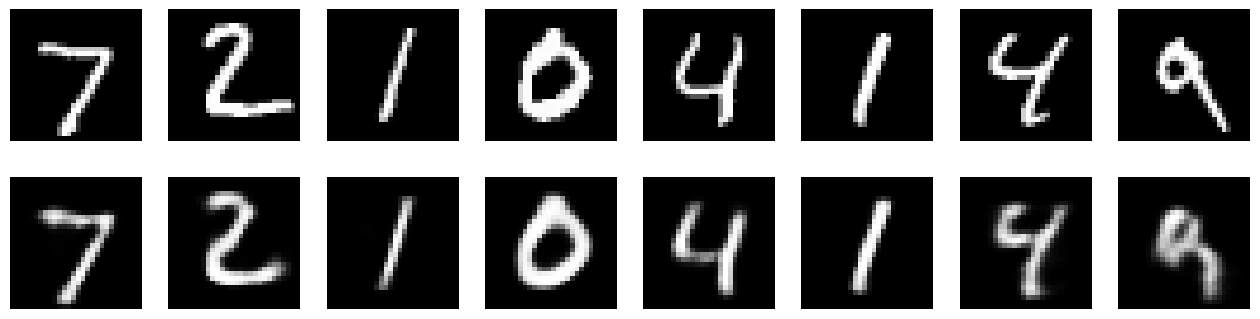

訓練完成!
已儲存重建圖檔 reconstruction.png


In [36]:
model.eval() #評估模式
with torch.no_grad():
  test_batch, _ = next(iter(test_loader))
  test_batch = test_batch.to(device)
  recon_batch, _, _ = model(test_batch)

  #顯示前8張input和reconstruction
  n = 8
  plt.figure(figsize=(16, 4))
  for i in range(n):
    #input
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_batch[i].cpu().numpy().reshape(28, 28), cmap="gray")
    ax.axis("off")

    #reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_batch[i].cpu().numpy().reshape(28, 28), cmap="gray")
    ax.axis("off")

  #儲存成.png
  plt.savefig("reconstruction.png")
  plt.show()

# 顯示每個 epoch 的平均 loss
print("訓練完成!")
print("已儲存重建圖檔 reconstruction.png")
